In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import shap

## Data Loading

In [2]:
df = pd.read_csv('BankChurners.csv')

In [3]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [4]:
df.drop(df.columns[-2:], axis=1, inplace=True)
df = df.drop(columns=['CLIENTNUM'])

In [5]:
unknown_counts = {}

for column_name in df.columns:
    has_unknown = (df[column_name] == 'Unknown').any()
    if has_unknown:
        # Count the number of 'Unknown' values in the column
        unknown_count = (df[column_name] == 'Unknown').sum()
        unknown_counts[column_name] = unknown_count
        print(f'{column_name} contains unknown values: {unknown_count}')
    else:
        pass

Education_Level contains unknown values: 1519
Marital_Status contains unknown values: 749
Income_Category contains unknown values: 1112


## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

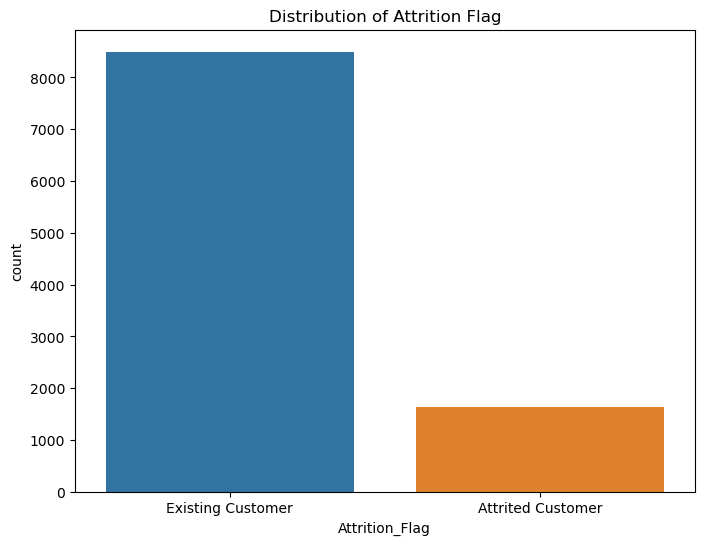

In [6]:
# Basic Information
print(df.info())

# Distribution of Target Variable (Attrition_Flag)
plt.figure(figsize=(8, 6))
sns.countplot(x='Attrition_Flag', data=df)
plt.title('Distribution of Attrition Flag')
plt.show()

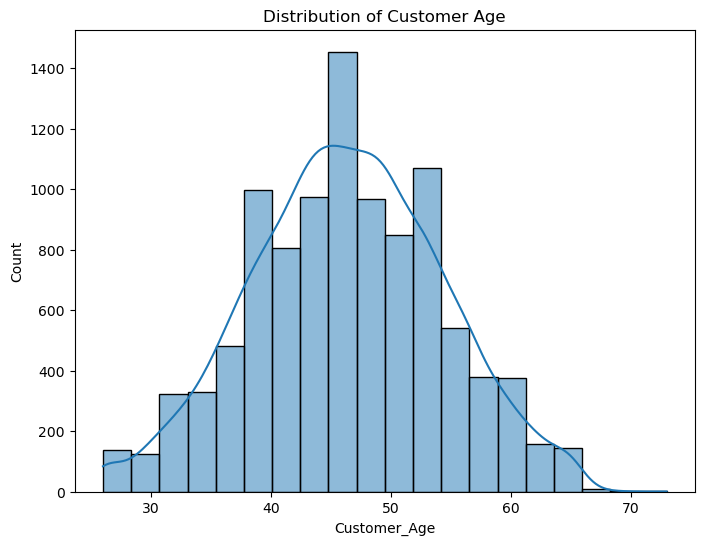

In [7]:
# Customer Age Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Customer_Age'], bins=20, kde=True)
plt.title('Distribution of Customer Age')
plt.show()

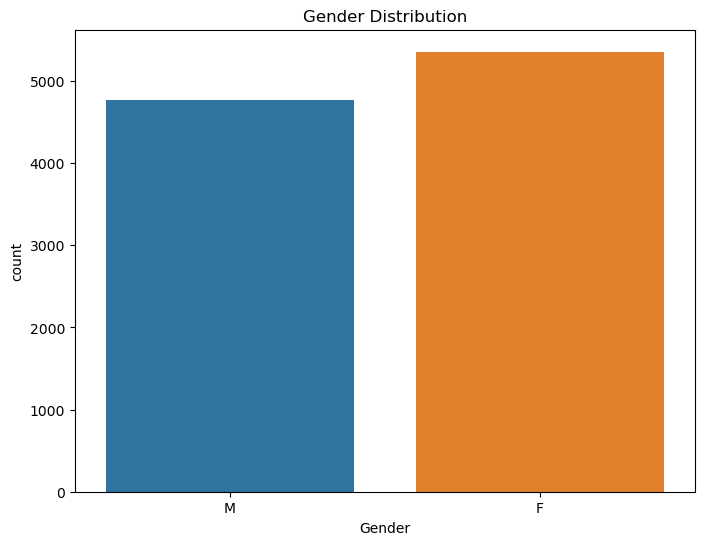

In [8]:
# Gender Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.show()

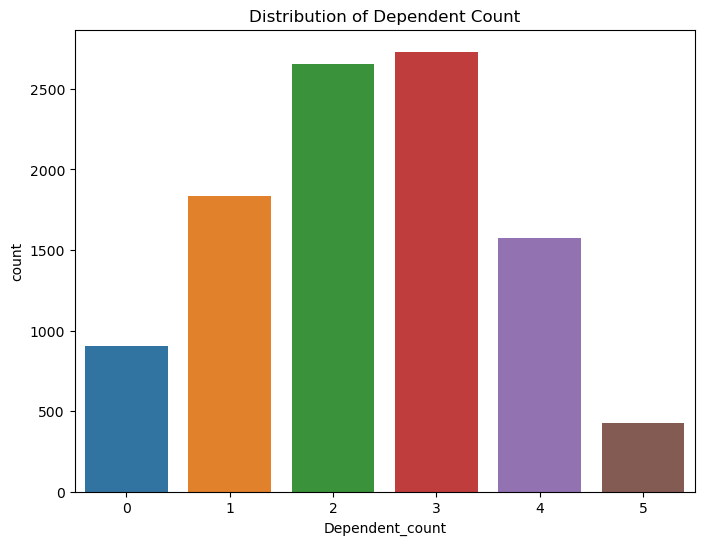

In [9]:
# Distribution of Dependent Count
plt.figure(figsize=(8, 6))
sns.countplot(x='Dependent_count', data=df)
plt.title('Distribution of Dependent Count')
plt.show()

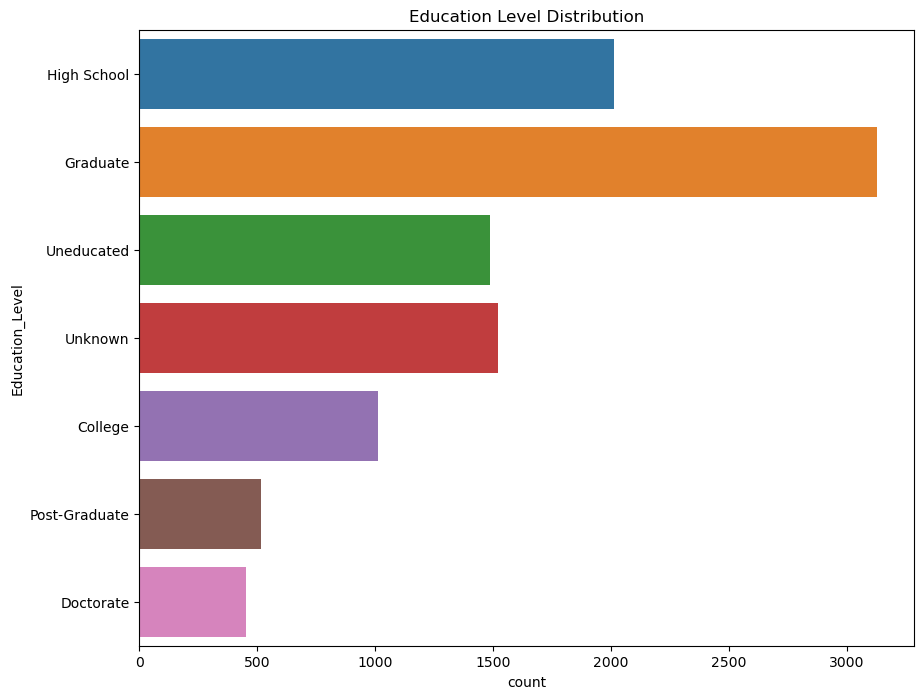

In [10]:
# Education Level Distribution
plt.figure(figsize=(10, 8))
sns.countplot(y='Education_Level', data=df)
plt.title('Education Level Distribution')
plt.show()

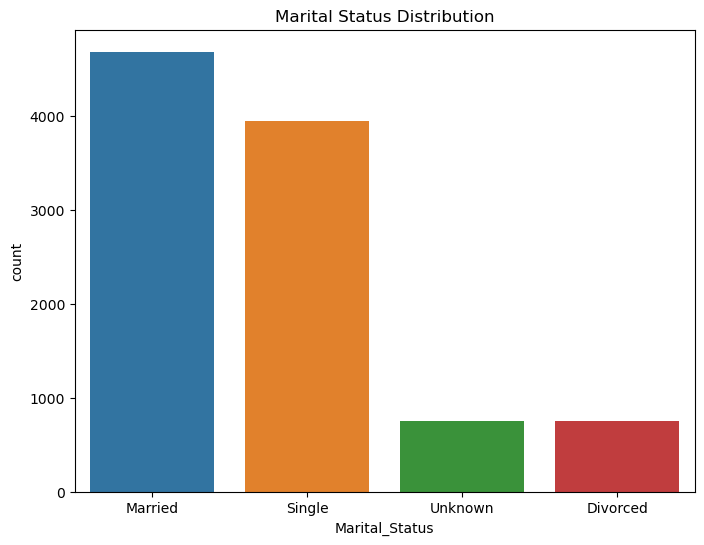

In [11]:
# Marital Status Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Marital_Status', data=df)
plt.title('Marital Status Distribution')
plt.show()

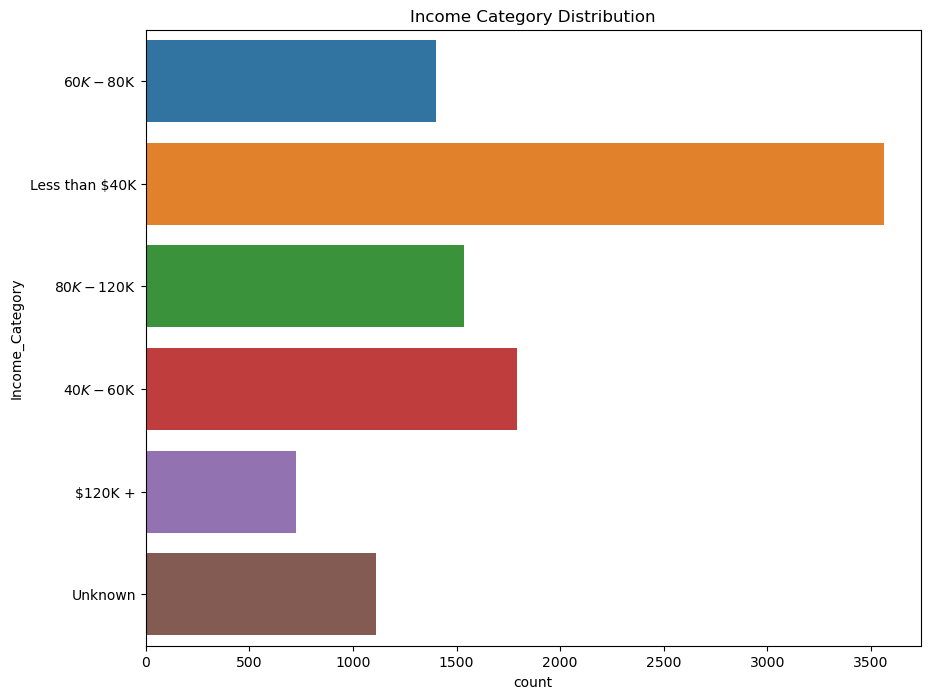

In [12]:
# Income Category Distribution
plt.figure(figsize=(10, 8))
sns.countplot(y='Income_Category', data=df)
plt.title('Income Category Distribution')
plt.show()

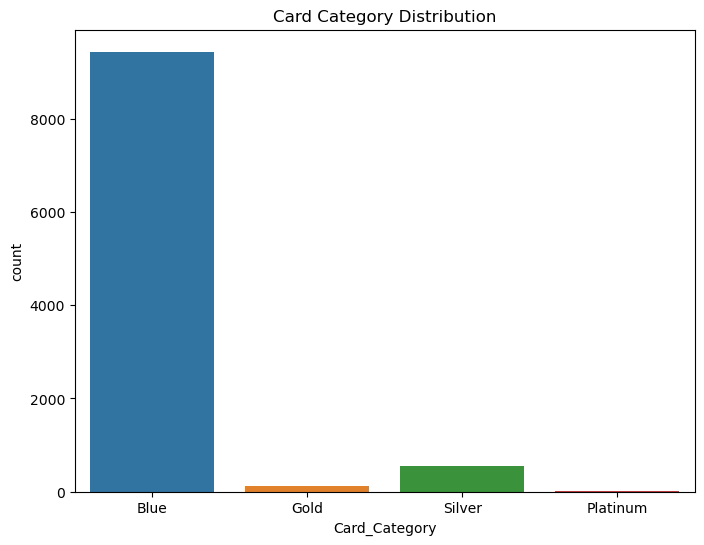

In [13]:
# Card Category Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Card_Category', data=df)
plt.title('Card Category Distribution')
plt.show()

/Users/akshayvarma/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


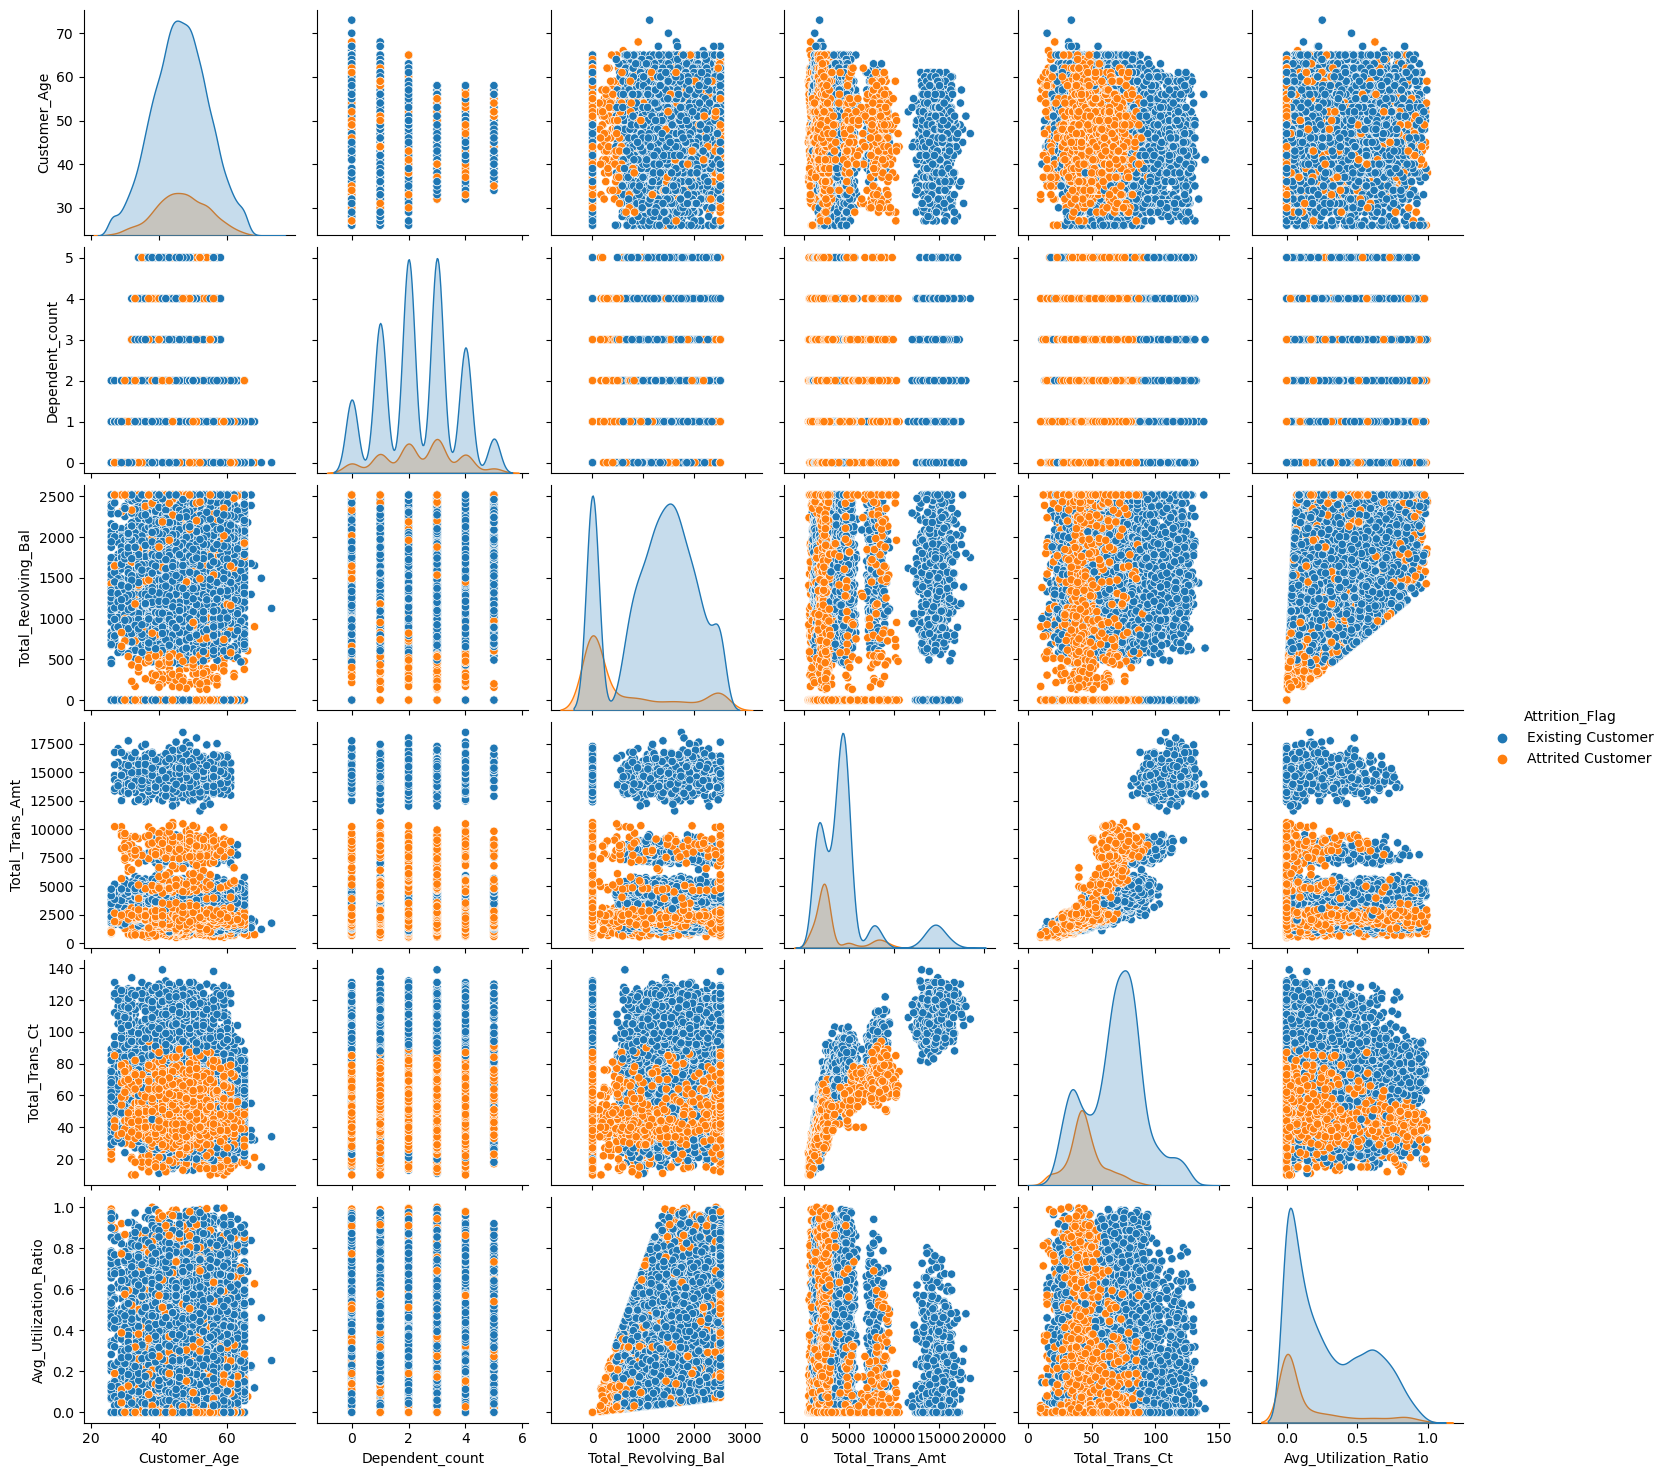

In [14]:
# Pairplot for Selected Features
# Selecting a subset of features for readability
selected_features = ['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Income_Category', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio', 'Attrition_Flag']
sns.pairplot(df[selected_features], hue='Attrition_Flag')
plt.show()

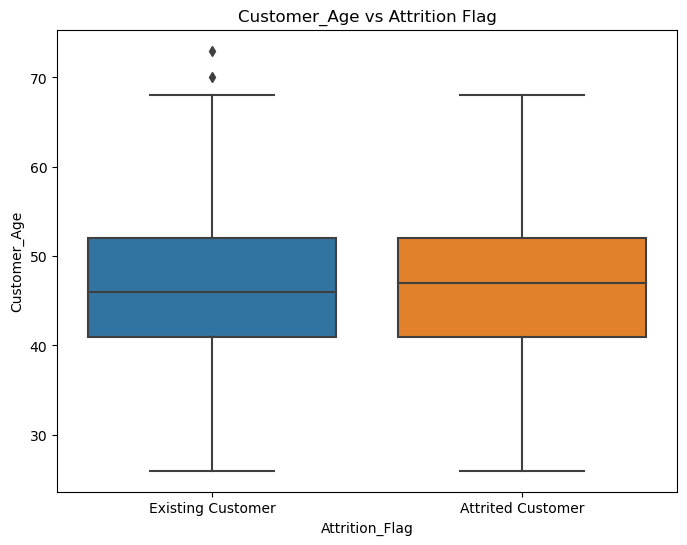

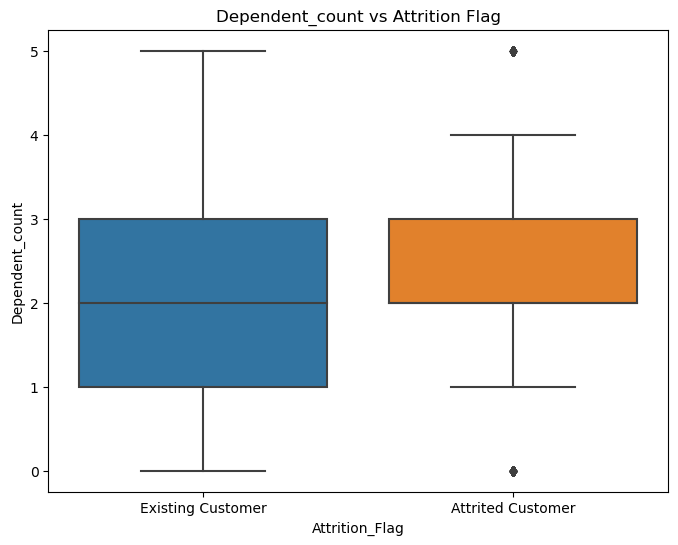

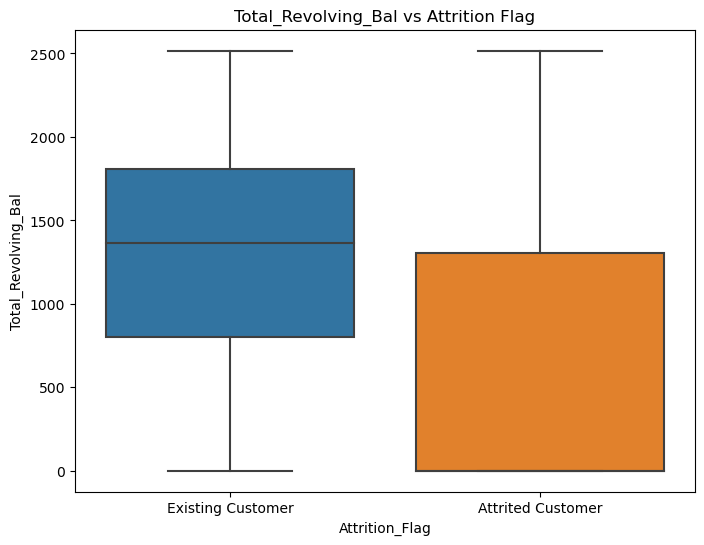

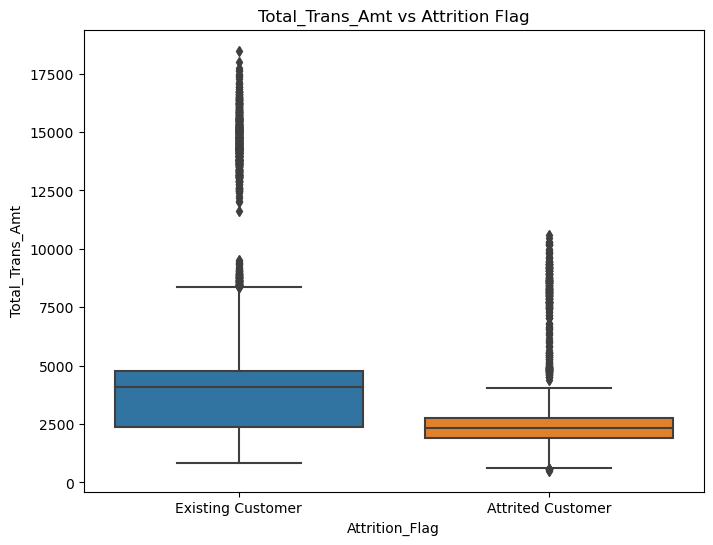

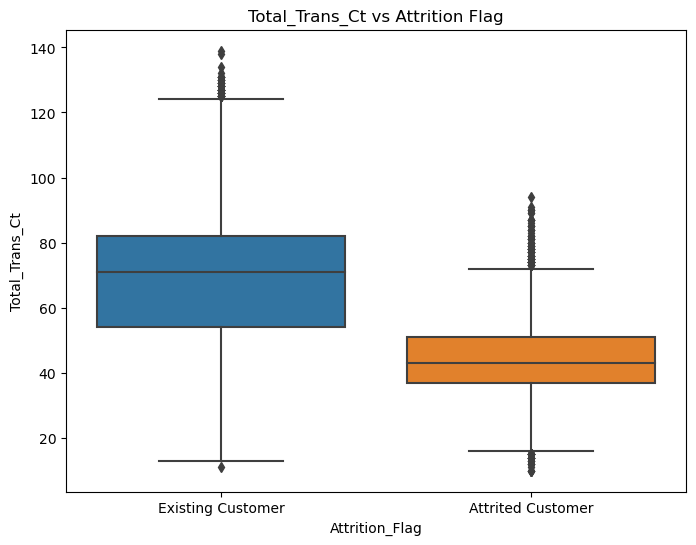

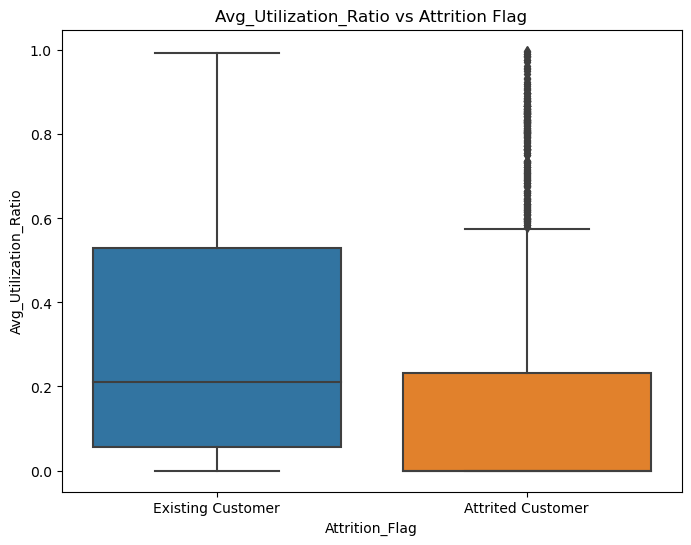

In [15]:
# Boxplot for Numeric Features vs Attrition Flag
numeric_features = ['Customer_Age', 'Dependent_count', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio']
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Attrition_Flag', y=feature, data=df)
    plt.title(f'{feature} vs Attrition Flag')
    plt.show()

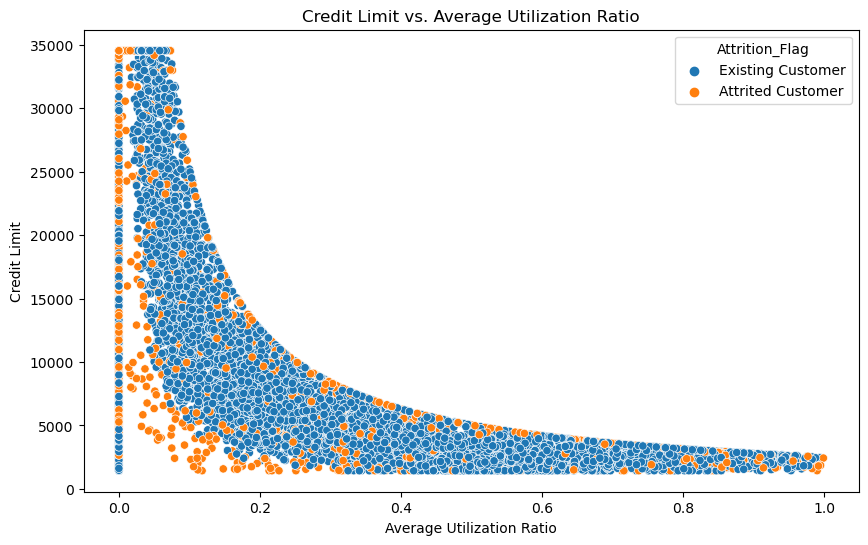

In [16]:
# Credit Limit vs. Utilization Ratio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Avg_Utilization_Ratio', y='Credit_Limit', hue='Attrition_Flag', data=df)
plt.title('Credit Limit vs. Average Utilization Ratio')
plt.xlabel('Average Utilization Ratio')
plt.ylabel('Credit Limit')
plt.show()

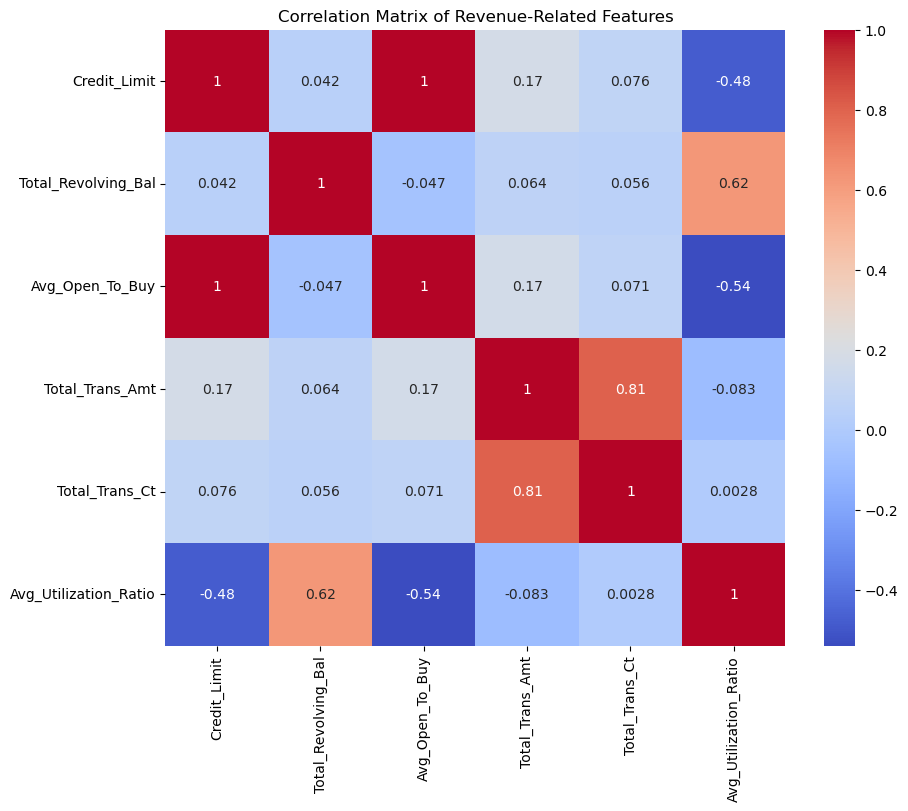

In [17]:
# Correlation Matrix with Revenue-Related Features
revenue_features = ['Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio']
corr = df[revenue_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Revenue-Related Features')
plt.show()

## Data Processing for training model

In [18]:
# Data Preprocessing
# Convert categorical variables to numeric
label_encoders = {}
for column in ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    
# Split the data into features and target label
X = df.drop(['Attrition_Flag'], axis=1)
y = df['Attrition_Flag']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
# Handling Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote == 0))) 

After OverSampling, counts of label '1': 6801
After OverSampling, counts of label '0': 6801


## Model Training

In [20]:
# Model Training with XGBoost
model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_smote, y_train_smote)

# Hyperparameter Tuning with Randomized Search
params = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1],
    'subsample': [0.2, 0.4, 0.6, 0.8, 1]
}

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, random_state=42)
random_search.fit(X_train_smote, y_train_smote)

# Using the best model from random search
best_model = random_search.best_estimator_

# Predictions and Evaluation
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       327
           1       0.98      0.98      0.98      1699

    accuracy                           0.96      2026
   macro avg       0.93      0.93      0.93      2026
weighted avg       0.96      0.96      0.96      2026



In [21]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Accuracy: 0.9630
Precision: 0.9788
Recall: 0.9770
F1 Score: 0.9779
ROC-AUC Score: 0.9335


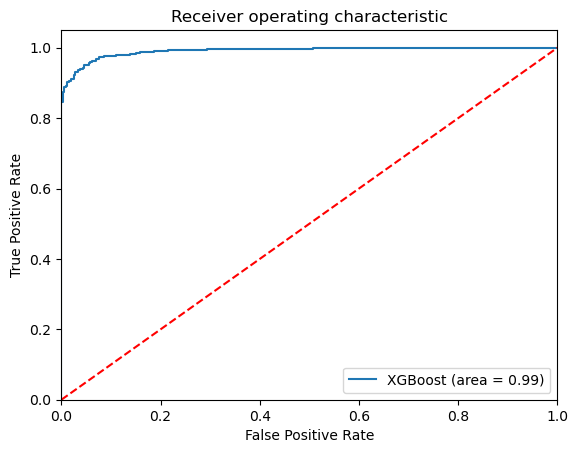

In [22]:
# Model Evaluation: AUC-ROC Curve
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

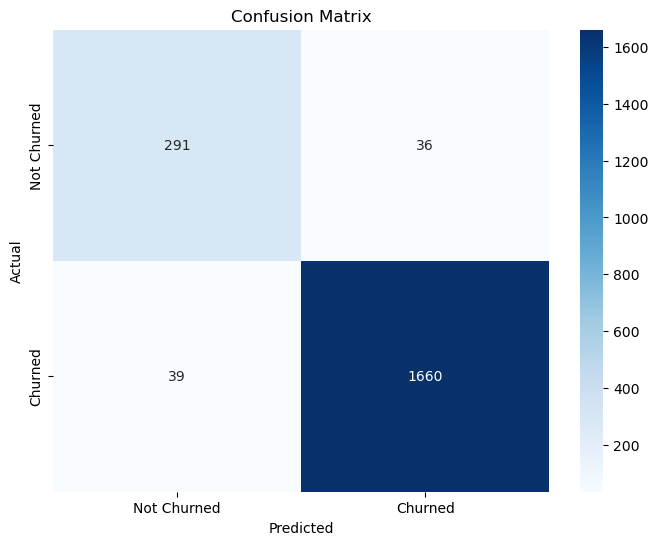

In [23]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

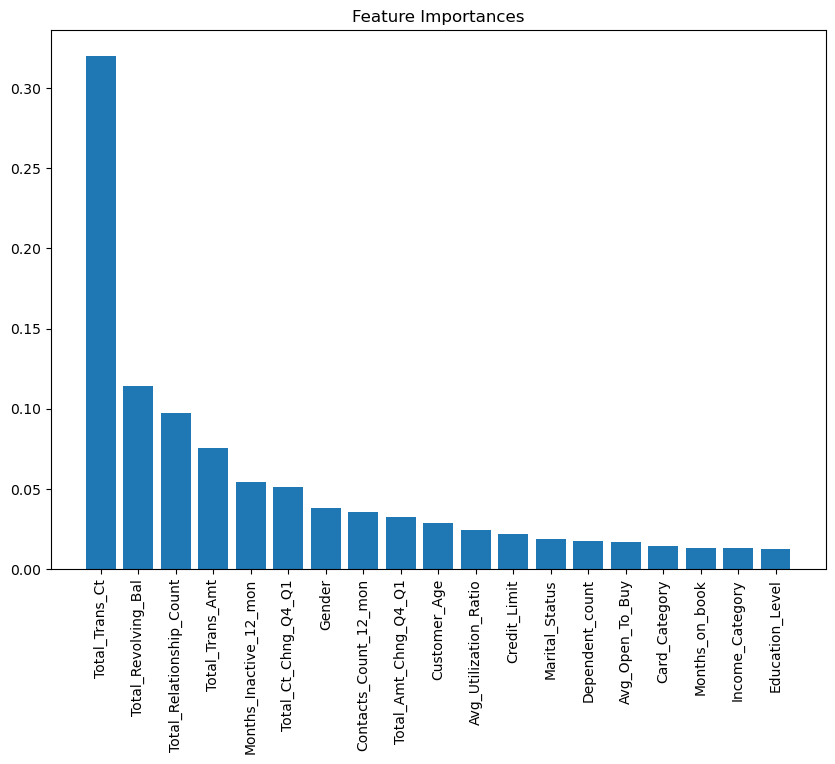

In [24]:
# Feature Importance
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 7))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[sorted_idx], align="center")
plt.xticks(range(X.shape[1]), X.columns[sorted_idx], rotation=90)
plt.show()

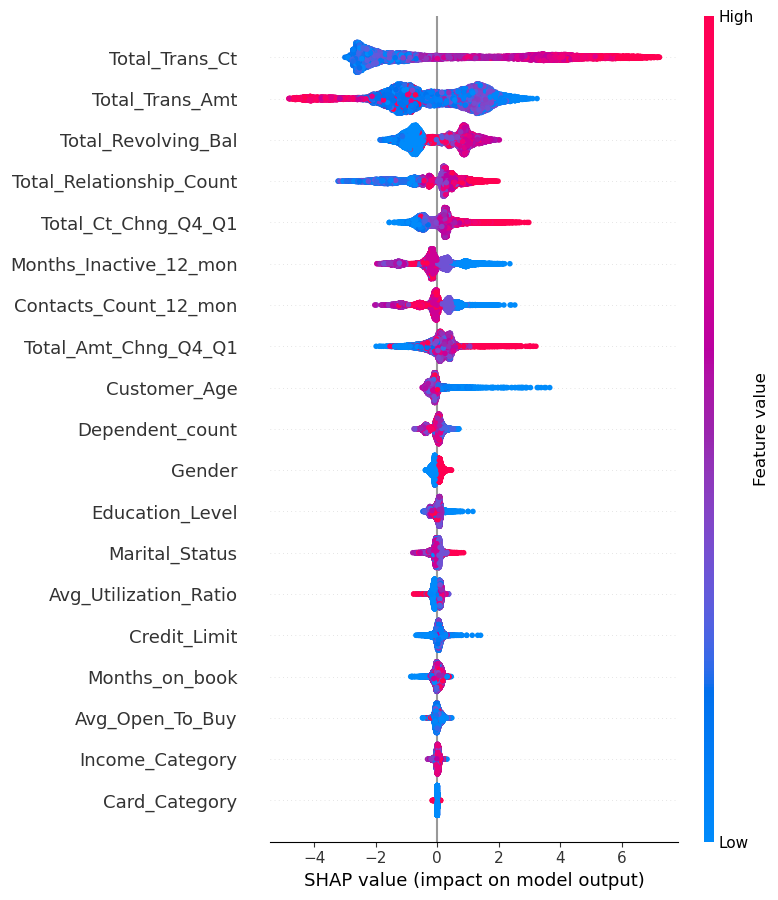

In [25]:
# Model Explainability with SHAP
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_smote)

# Plot summary plot
shap.summary_plot(shap_values, X_train_smote, feature_names=X.columns)
